<a href="https://colab.research.google.com/github/SiddanshChawla/stock_forecasting/blob/main/gru_for_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import re   
import nltk  
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
import string
from textblob import TextBlob
import spacy
nlp=spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score,recall_score
import seaborn as sns

In [5]:
data = pd.read_csv('/content/financial news data.csv',encoding='latin-1',header = None)

In [6]:
data.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [7]:
data.columns = ['sentiment','news']

<Axes: xlabel='sentiment'>

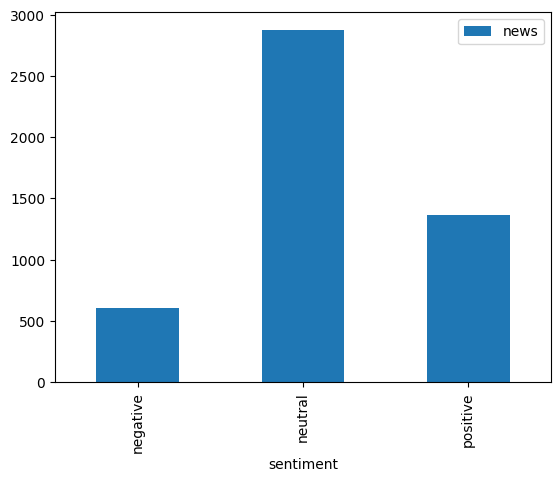

In [8]:
data.groupby('sentiment').count().plot(kind='bar')


In [28]:
def read_data():
    dataset=pd.read_csv('/content/financial news data.csv',encoding='latin-1',
                header=None,
                 names=['Sentiment','News'])
    return dataset

def convert_to_lower_case():
    def lower(input_text):
        return input_text.lower()
    dataset['News']=dataset['News'].apply(lower)
    
def remove_punctuation():
    def remove_punctuation_from_text(input_text):
        output_list=[word for word in input_text.split() if word.isalpha()]
        return ' '.join(output_list)    
    dataset['News']=dataset['News'].apply(remove_punctuation_from_text)
    
def correct_words():
    def correct_text(input_text):
        list_1=[str(TextBlob(word).correct()) for word in input_text.split()]
        output_text= ' '.join(list_1)
        return output_text
    dataset['News']=dataset['News'].apply(correct_text)
    
def lemmatize():
    def lematize_text(input_text):
        doc=nlp(input_text)
        lemmas=[token.lemma_ for token in doc]
        output_text=' '.join(lemmas)
        return output_text
    dataset['News']=dataset['News'].apply(lematize_text)
    
def remove_stopwords():
    def remove_stopwords_from_text(input_text):
        stopwords=spacy.lang.en.stop_words.STOP_WORDS
        output_list=[word for word in input_text.split() if word not in stopwords and not(word=='-PRON-') ]
        return ' '.join(output_list)
    dataset['News']=dataset['News'].apply(remove_stopwords_from_text)

def filter_the_neutral_news():
    return dataset[dataset['Sentiment']!='neutral']

def create_target_and_input():
    target=dataset['Sentiment'].values.tolist()
    target=[1 if sentiment=='positive' else 0 for sentiment in target]
    data=dataset['News'].values.tolist()
    return data,target

def split_train_test():
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42,stratify=target)
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    return x_train, x_test, y_train, y_test 

In [29]:
dataset=read_data()
convert_to_lower_case()
remove_punctuation()
lemmatize()
remove_stopwords()
dataset=filter_the_neutral_news()
data, target  =create_target_and_input()
x_train, x_test, y_train, y_test =split_train_test()

In [56]:

num_words=1000
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data)

x_train_tokens=tokenizer.texts_to_sequences(x_train)
x_test_tokens=tokenizer.texts_to_sequences(x_test)



In [57]:

num_tokens=[len(tokens) for tokens in x_train_tokens+x_test_tokens]
num_tokens=np.array(num_tokens)
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)



In [58]:
x_train_pad=pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad=pad_sequences(x_test_tokens, maxlen=max_tokens)

In [61]:
model=Sequential()
embedding_size=50
model.add(Embedding(input_dim=num_words, output_dim=embedding_size, input_length=max_tokens,name='embedding_layer')) 

model.add(GRU(units=16,return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1,activation='sigmoid'))
optimizer=Adam(lr=1e-3)

In [62]:
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [63]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 18, 50)           50000     
                                                                 
 gru_3 (GRU)                 (None, 18, 16)            3264      
                                                                 
 gru_4 (GRU)                 (None, 18, 8)             624       
                                                                 
 gru_5 (GRU)                 (None, 4)                 168       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 54,061
Trainable params: 54,061
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(x_train_pad, y_train,epochs=8)

Epoch 1/8
50/50 [==============================] - 6s 32ms/step - loss: 0.6207 - accuracy: 0.6879
Epoch 2/8
50/50 [==============================] - 2s 32ms/step - loss: 0.4653 - accuracy: 0.7845
Epoch 3/8
50/50 [==============================] - 2s 45ms/step - loss: 0.3007 - accuracy: 0.8773
Epoch 4/8
50/50 [==============================] - 2s 39ms/step - loss: 0.2284 - accuracy: 0.9142
Epoch 5/8
50/50 [==============================] - 2s 32ms/step - loss: 0.1956 - accuracy: 0.9332
Epoch 6/8
50/50 [==============================] - 2s 31ms/step - loss: 0.1643 - accuracy: 0.9447
Epoch 7/8
50/50 [==============================] - 2s 32ms/step - loss: 0.1517 - accuracy: 0.9498
Epoch 8/8
50/50 [==============================] - 2s 32ms/step - loss: 0.1450 - accuracy: 0.9510


In [66]:
result=model.evaluate(x_test_pad,y_test)

13/13 [==============================] - 1s 8ms/step - loss: 0.4729 - accuracy: 0.8096
